In [ ]:
from tensorflow import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.models import Sequential
from keras.layers.convolutional import ZeroPadding2D
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/biometrics/all_teath_labeles.csv")
df

In [ ]:
missing = df.isnull().sum()
missing


img                             0
9-gummy                         0
16-Incisal\nEmbrasure           0
4-color                         0
52-Crooked                      0
41-Central Incisor W/H Ratio    0
dtype: int64

In [ ]:
classes = ['9-gummy', '16-Incisal\nEmbrasure', '4-color', '52-Crooked', '41-Central Incisor W/H Ratio']


In [ ]:
train_data_generation = ImageDataGenerator(rescale=1./255)

training_set = train_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/Colab Notebooks/biometrics/Splitted/train",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(rescale=1./255)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/Colab Notebooks/biometrics/Splitted/val",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)


test_set = test_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/Colab Notebooks/biometrics/Splitted/test",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(44, 224, 224, 3) (44, 5)


[0 0 0 0 0]


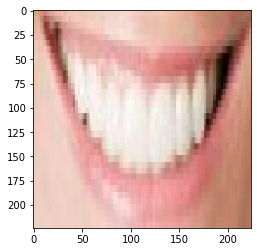

In [ ]:
from matplotlib.image import imread
print(y_test[2])
plt.imshow(X_test[2])


In [ ]:
img =next(training_set)
# #print(classes)

# l=[]
# for i, x in enumerate(classes):
#     if img[1][0][i]==1 :
#         l.append(x)

# print("image labels:")
# print(l)

# img=img[0][0]  #first image
# #print(img.shape)
# # print(img)
# plt.imshow(img)
# training_set.reset()
print(img)

In [ ]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
#model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Dropout(0.1))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

# model.load_weights('vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False
model.get_layer("conv5_3").trainable =True
model.get_layer("conv5_2").trainable =True
#model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_3").trainable =True
model.get_layer("conv3_3").trainable =True

#adding output layers
model.add(Flatten())
#model.add(Dropout(0.1))
#model.add( Dense(16, activation='relu'))
model.add( Dense(16, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)))

model.add(Dense(5, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 53, 53, 128)      0         
 2D)                                                  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=20,mode='max',restore_best_weights=True)
initial_learning_rate = 0.002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=([es]))


Epoch 1/100
10/10 [==============================] - 68s 5s/step - loss: 0.9147 - binary_accuracy: 0.5980 - val_loss: 0.8205 - val_binary_accuracy: 0.5837
Epoch 2/100
10/10 [==============================] - 4s 400ms/step - loss: 0.7802 - binary_accuracy: 0.6189 - val_loss: 0.7342 - val_binary_accuracy: 0.6163
Epoch 3/100
10/10 [==============================] - 4s 385ms/step - loss: 0.7112 - binary_accuracy: 0.6221 - val_loss: 0.6875 - val_binary_accuracy: 0.6163
Epoch 4/100
10/10 [==============================] - 5s 493ms/step - loss: 0.6740 - binary_accuracy: 0.6443 - val_loss: 0.6657 - val_binary_accuracy: 0.6395
Epoch 5/100
10/10 [==============================] - 4s 411ms/step - loss: 0.6579 - binary_accuracy: 0.6476 - val_loss: 0.6570 - val_binary_accuracy: 0.6395
Epoch 6/100
10/10 [==============================] - 4s 390ms/step - loss: 0.6475 - binary_accuracy: 0.6476 - val_loss: 0.6483 - val_binary_accuracy: 0.6395
Epoch 7/100
10/10 [==============================] - 4s 394m

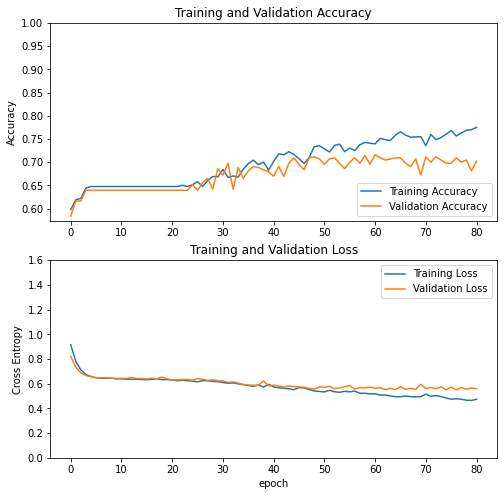

In [ ]:

#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.3]=1
    pred[pred<=0.3]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)
# predictions

,0,1,2,3,4
0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,0.0,1.0
2,1.0,1.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0
5,0.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,0.0,1.0
7,0.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0


In [ ]:
from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.11      0.33      0.17         6
        16-Incisal
Embrasure       0.71      0.85      0.77        26
                     4-color       0.70      0.91      0.79        23
                  52-Crooked       0.53      0.77      0.62        13
41-Central Incisor W/H Ratio       0.67      0.85      0.75        26

                   micro avg       0.59      0.82      0.68        94
                   macro avg       0.54      0.74      0.62        94
                weighted avg       0.63      0.82      0.71        94
                 samples avg       0.44      0.58      0.48        94



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.2]=1
    pred[pred<=0.2]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)
# predictions

,0,1,2,3,4
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,0.0,1.0
2,1.0,1.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,0.0,1.0
7,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0


In [ ]:
print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.11      0.50      0.18         6
        16-Incisal
Embrasure       0.65      0.92      0.76        26
                     4-color       0.71      0.96      0.81        23
                  52-Crooked       0.50      0.77      0.61        13
41-Central Incisor W/H Ratio       0.66      0.96      0.78        26

                   micro avg       0.55      0.89      0.68        94
                   macro avg       0.52      0.82      0.63        94
                weighted avg       0.61      0.89      0.72        94
                 samples avg       0.46      0.64      0.52        94



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
#model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Dropout(0.1))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.load_weights('/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False
model.get_layer("conv5_3").trainable =True
model.get_layer("conv5_2").trainable =True
#model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_3").trainable =True
model.get_layer("conv3_3").trainable =True

#adding output layers
model.add(Flatten())
#model.add(Dropout(0.1))
#model.add( Dense(16, activation='relu'))
model.add( Dense(16, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)))

model.add(Dense(5, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=20,mode='max',restore_best_weights=True)
initial_learning_rate = 0.002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=([es]))

Epoch 1/100
10/10 [==============================] - 72s 5s/step - loss: 0.9731 - binary_accuracy: 0.5844 - val_loss: 0.8271 - val_binary_accuracy: 0.6395
Epoch 2/100
10/10 [==============================] - 4s 391ms/step - loss: 0.7848 - binary_accuracy: 0.6397 - val_loss: 0.7581 - val_binary_accuracy: 0.6070
Epoch 3/100
10/10 [==============================] - 5s 477ms/step - loss: 0.7197 - binary_accuracy: 0.6476 - val_loss: 0.6955 - val_binary_accuracy: 0.6395
Epoch 4/100
10/10 [==============================] - 4s 392ms/step - loss: 0.6758 - binary_accuracy: 0.6476 - val_loss: 0.6723 - val_binary_accuracy: 0.6395
Epoch 5/100
10/10 [==============================] - 4s 399ms/step - loss: 0.6520 - binary_accuracy: 0.6476 - val_loss: 0.6692 - val_binary_accuracy: 0.6395
Epoch 6/100
10/10 [==============================] - 4s 384ms/step - loss: 0.6455 - binary_accuracy: 0.6482 - val_loss: 0.6672 - val_binary_accuracy: 0.6395
Epoch 7/100
10/10 [==============================] - 4s 392m

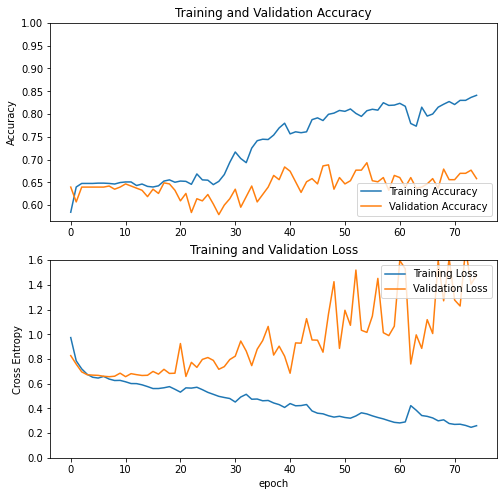

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.3]=1
    pred[pred<=0.3]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)
# predictions

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0
5,0.0,1.0,1.0,1.0,1.0
6,0.0,0.0,1.0,0.0,1.0
7,0.0,1.0,1.0,1.0,1.0
8,0.0,1.0,1.0,0.0,1.0
9,1.0,1.0,1.0,1.0,1.0


In [ ]:
from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.36      0.67      0.47         6
        16-Incisal
Embrasure       0.69      0.92      0.79        26
                     4-color       0.61      1.00      0.75        23
                  52-Crooked       0.36      0.38      0.37        13
41-Central Incisor W/H Ratio       0.59      1.00      0.74        26

                   micro avg       0.58      0.87      0.69        94
                   macro avg       0.52      0.79      0.62        94
                weighted avg       0.57      0.87      0.69        94
                 samples avg       0.53      0.66      0.56        94



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# load images in dataframe from saving directory 
# pationing dataset to 80:10:10 , train:valid:test sets
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 2/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/Colab Notebooks/biometrics/Splitted/train",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/Colab Notebooks/biometrics/Splitted/val",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/Colab Notebooks/biometrics/Splitted/test",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)

NameError: ignored

In [ ]:
# Store the data in X_test, y_test variables by iterating over the batches
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(44, 224, 224, 3) (44, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image labels:
['16-Incisal\nEmbrasure', '4-color']
-0.6947267


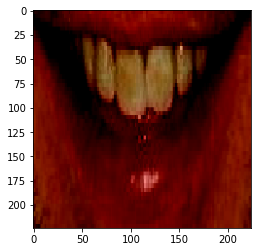

In [ ]:
img =next(training_set)
#print(classes)

l=[]
for i, x in enumerate(classes):
    if img[1][0][i]==1 :
        l.append(x)

print("image labels:")
print(l)

img=img[0][0]  #first image
#print(img.shape)
# print(img)
print(np.amin(img.flatten()))
plt.imshow(img)
training_set.reset()

In [ ]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

# model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False

model.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_2").trainable =True
model.get_layer("conv5_3").trainable =True
model.get_layer("conv5_1").trainable =True


#adding output layers
model.add(Flatten())

model.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(5, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
model1 = Sequential()
model1.add(keras.Input(shape=(224,224,3)))
model1.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model1.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model1.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model1.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model1.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model1.add(MaxPool2D((2,2), strides=(2,2)))
 
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.load_weights('/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model1.layers:
    layer.trainable = False

model1.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model1.get_layer("conv4_1").trainable =True
model1.get_layer("conv4_2").trainable =True
model1.get_layer("conv5_3").trainable =True
model1.get_layer("conv5_1").trainable =True


#adding output layers
model1.add(Flatten())

model1.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model1.add(BatchNormalization())
model1.add(Activation("relu"))

model1.add(Dropout(0.5))

model1.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model1.add(BatchNormalization())
model1.add(Activation("relu"))

model1.add(Dense(5, activation='sigmoid'))
# summarize

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=20,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model.fit(x=training_set, validation_data=valid_set, epochs=100 , shuffle =True,callbacks=[es])

Epoch 1/100
20/20 [==============================] - 7s 266ms/step - loss: 1.1585 - binary_accuracy: 0.6834 - val_loss: 1.1626 - val_binary_accuracy: 0.6791
Epoch 2/100
20/20 [==============================] - 5s 247ms/step - loss: 1.0725 - binary_accuracy: 0.7088 - val_loss: 1.1410 - val_binary_accuracy: 0.6047
Epoch 3/100
20/20 [==============================] - 5s 241ms/step - loss: 1.0212 - binary_accuracy: 0.7134 - val_loss: 1.0876 - val_binary_accuracy: 0.6209
Epoch 4/100
20/20 [==============================] - 5s 239ms/step - loss: 0.9731 - binary_accuracy: 0.7140 - val_loss: 1.0377 - val_binary_accuracy: 0.6070
Epoch 5/100
20/20 [==============================] - 5s 238ms/step - loss: 0.9330 - binary_accuracy: 0.7173 - val_loss: 0.9901 - val_binary_accuracy: 0.6279
Epoch 6/100
20/20 [==============================] - 5s 240ms/step - loss: 0.9143 - binary_accuracy: 0.7186 - val_loss: 0.9717 - val_binary_accuracy: 0.6977
Epoch 7/100
20/20 [==============================] - 5s 24

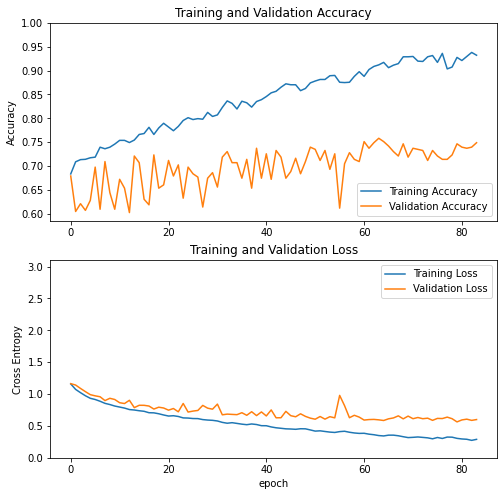

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.3]=1
    pred[pred<=0.3]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)

,0,1,2,3,4
0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0
5,0.0,1.0,1.0,0.0,1.0
6,0.0,1.0,1.0,1.0,1.0
7,0.0,1.0,1.0,1.0,1.0
8,0.0,1.0,1.0,0.0,1.0
9,1.0,1.0,1.0,1.0,1.0


In [ ]:
from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.38      0.50      0.43         6
        16-Incisal
Embrasure       0.76      0.85      0.80        26
                     4-color       0.72      1.00      0.84        23
                  52-Crooked       0.50      0.77      0.61        13
41-Central Incisor W/H Ratio       0.68      0.96      0.79        26

                   micro avg       0.66      0.88      0.75        94
                   macro avg       0.61      0.82      0.69        94
                weighted avg       0.67      0.88      0.76        94
                 samples avg       0.53      0.64      0.56        94



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=20,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history1=model1.fit(x=training_set, validation_data=valid_set, epochs=100 , shuffle =True,callbacks=[es])

Epoch 1/100
20/20 [==============================] - 7s 268ms/step - loss: 1.6768 - binary_accuracy: 0.7277 - val_loss: 1.6609 - val_binary_accuracy: 0.6837
Epoch 2/100
20/20 [==============================] - 5s 244ms/step - loss: 1.5549 - binary_accuracy: 0.7381 - val_loss: 1.5291 - val_binary_accuracy: 0.7581
Epoch 3/100
20/20 [==============================] - 5s 244ms/step - loss: 1.4615 - binary_accuracy: 0.7479 - val_loss: 1.5874 - val_binary_accuracy: 0.6419
Epoch 4/100
20/20 [==============================] - 5s 239ms/step - loss: 1.3712 - binary_accuracy: 0.7564 - val_loss: 1.3635 - val_binary_accuracy: 0.7465
Epoch 5/100
20/20 [==============================] - 5s 242ms/step - loss: 1.2956 - binary_accuracy: 0.7577 - val_loss: 1.3135 - val_binary_accuracy: 0.7279
Epoch 6/100
20/20 [==============================] - 5s 239ms/step - loss: 1.2296 - binary_accuracy: 0.7759 - val_loss: 1.2558 - val_binary_accuracy: 0.7047
Epoch 7/100
20/20 [==============================] - 5s 23

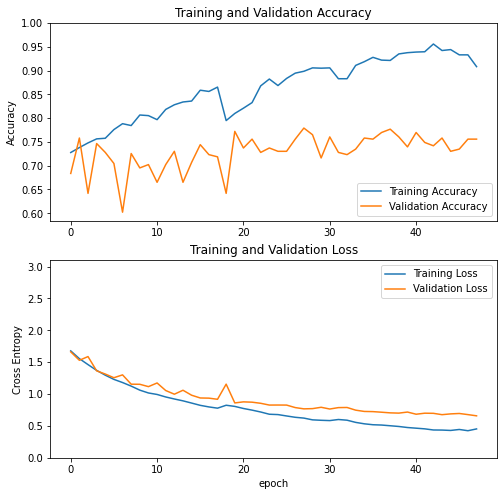

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history1.history['binary_accuracy']
val_acc = history1.history['val_binary_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions1= model1.predict(test_set)
y_pred1=[]
for pred in predictions1:
    pred[pred>0.3]=1
    pred[pred<=0.3]=0
    y_pred1.append(pred)

y_pred1 = np.array(y_pred1)
pd.DataFrame(predictions1)

,0,1,2,3,4
0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0
5,0.0,1.0,1.0,0.0,1.0
6,0.0,1.0,1.0,1.0,1.0
7,0.0,1.0,1.0,1.0,1.0
8,0.0,1.0,1.0,0.0,1.0
9,1.0,1.0,1.0,0.0,1.0


In [ ]:

print(classification_report(y_test, y_pred1,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.44      0.67      0.53         6
        16-Incisal
Embrasure       0.73      0.92      0.81        26
                     4-color       0.62      1.00      0.77        23
                  52-Crooked       0.58      0.54      0.56        13
41-Central Incisor W/H Ratio       0.67      1.00      0.80        26

                   micro avg       0.65      0.89      0.75        94
                   macro avg       0.61      0.83      0.69        94
                weighted avg       0.65      0.89      0.75        94
                 samples avg       0.55      0.69      0.59        94



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Clone the entire repo.
!git clone "https://github.com/moheb432/principles-of-smile.git"

Cloning into 'principles-of-smile'...
remote: Enumerating objects: 6479, done.
remote: Counting objects: 100% (1700/1700), done.
remote: Compressing objects: 100% (1695/1695), done.
remote: Total 6479 (delta 17), reused 1682 (delta 5), pack-reused 4779
Receiving objects: 100% (6479/6479), 341.14 MiB | 30.89 MiB/s, done.
Resolving deltas: 100% (280/280), done.
Checking out files: 100% (6389/6389), done.


In [ ]:
df = pd.read_csv("dataset_and_augmented.csv")
classes = ['9-gummy', '16-Incisal Embrasure', '4-color', '52-Crooked', '41-Central Incisor W/H Ratio']
df=df.iloc[:,0:6]
df

,img,9-gummy,16-Incisal Embrasure,4-color,52-Crooked,41-Central Incisor W/H Ratio
0,41001_B.jpg,1,1,1,0,1
1,41002_B.jpg,0,1,1,0,1
2,41003_B.jpg,1,1,0,0,1
3,41004_B.jpg,1,1,1,0,1
4,41005_B.jpg,1,1,0,0,1
...,...,...,...,...,...,...
1738,aug_(c28)_0_167.jpg,0,1,1,1,1
1739,aug_(c28)_0_6823.jpg,0,1,1,1,1
1740,aug_(c28-a)_0_1100.jpg,0,0,0,0,0
1741,aug_(c28-a)_0_2337.jpg,0,0,0,0,0


In [ ]:
# load images in dataframe from saving directory 
# pationing dataset to 80:10:10 , train:valid:test sets
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 2/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/train",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/test",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/valid",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 426 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1395 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1317 validated image filenames.
Found 348 validated image filenames.
Found 76 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1667 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# Store the data in X_test, y_test variables by iterating over the batches
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(76, 224, 224, 3) (76, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image labels:
[]
-0.22181045


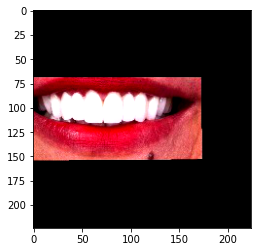

In [ ]:
img =next(training_set)
#print(classes)

l=[]
for i, x in enumerate(classes):
    if img[1][0][i]==1 :
        l.append(x)

print("image labels:")
print(l)

img=img[0][0]  #first image
#print(img.shape)
# print(img)
print(np.amin(img.flatten()))
plt.imshow(img)
training_set.reset()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=20,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history1=model1.fit(x=training_set, validation_data=valid_set, epochs=100 , shuffle =True,callbacks=[es])

Epoch 1/100
83/83 [==============================] - 29s 325ms/step - loss: 0.8319 - binary_accuracy: 0.7040 - val_loss: 0.8561 - val_binary_accuracy: 0.6529
Epoch 2/100
83/83 [==============================] - 19s 225ms/step - loss: 0.7176 - binary_accuracy: 0.7643 - val_loss: 0.7637 - val_binary_accuracy: 0.7144
Epoch 3/100
83/83 [==============================] - 19s 227ms/step - loss: 0.6542 - binary_accuracy: 0.7920 - val_loss: 0.7795 - val_binary_accuracy: 0.6833
Epoch 4/100
83/83 [==============================] - 19s 232ms/step - loss: 0.6124 - binary_accuracy: 0.8117 - val_loss: 0.7023 - val_binary_accuracy: 0.7190
Epoch 5/100
83/83 [==============================] - 19s 223ms/step - loss: 0.5622 - binary_accuracy: 0.8301 - val_loss: 0.6565 - val_binary_accuracy: 0.7500
Epoch 6/100
83/83 [==============================] - 19s 233ms/step - loss: 0.5167 - binary_accuracy: 0.8510 - val_loss: 0.6518 - val_binary_accuracy: 0.7282
Epoch 7/100
83/83 [==============================] -

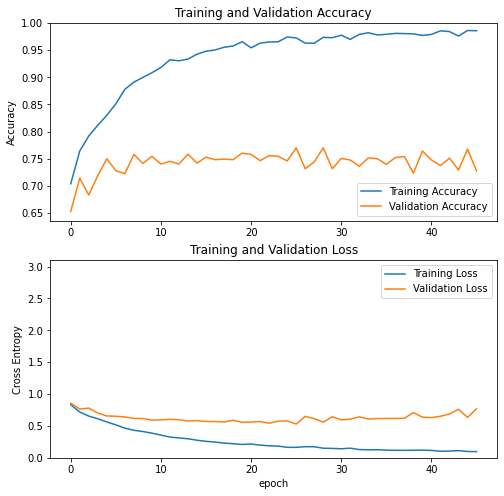

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history1.history['binary_accuracy']
val_acc = history1.history['val_binary_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions1= model1.predict(test_set)
y_pred1=[]
for pred in predictions1:
    pred[pred>0.3]=1
    pred[pred<=0.3]=0
    y_pred1.append(pred)

y_pred1 = np.array(y_pred1)
pd.DataFrame(predictions1)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0
72,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.0,1.0
74,1.0,0.0,0.0,0.0,1.0


In [ ]:
print(classification_report(y_test, y_pred1,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.62      0.65      0.63        20
        16-Incisal Embrasure       0.51      0.70      0.59        40
                     4-color       0.89      0.66      0.76        64
                  52-Crooked       0.40      0.75      0.52        16
41-Central Incisor W/H Ratio       0.82      0.86      0.84        64

                   micro avg       0.68      0.74      0.71       204
                   macro avg       0.65      0.72      0.67       204
                weighted avg       0.73      0.74      0.72       204
                 samples avg       0.60      0.65      0.59       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions2= model1.predict(test_set)
y_pred2=[]
for pred in predictions2:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred2.append(pred)

y_pred2 = np.array(y_pred2)
pd.DataFrame(predictions2)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0
72,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.0,1.0
74,1.0,0.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred2,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.54      0.35      0.42        20
        16-Incisal Embrasure       0.56      0.62      0.59        40
                     4-color       0.91      0.62      0.74        64
                  52-Crooked       0.42      0.69      0.52        16
41-Central Incisor W/H Ratio       0.83      0.70      0.76        64

                   micro avg       0.70      0.63      0.66       204
                   macro avg       0.65      0.60      0.61       204
                weighted avg       0.74      0.63      0.67       204
                 samples avg       0.56      0.55      0.53       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions3= model1.predict(test_set)
y_pred3=[]
for pred in predictions3:
    pred[pred>0.4]=1
    pred[pred<=0.4]=0
    y_pred3.append(pred)

y_pred3 = np.array(y_pred3)
pd.DataFrame(predictions3)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0
72,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.0,1.0
74,1.0,0.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred2,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.54      0.35      0.42        20
        16-Incisal Embrasure       0.56      0.62      0.59        40
                     4-color       0.91      0.62      0.74        64
                  52-Crooked       0.42      0.69      0.52        16
41-Central Incisor W/H Ratio       0.83      0.70      0.76        64

                   micro avg       0.70      0.63      0.66       204
                   macro avg       0.65      0.60      0.61       204
                weighted avg       0.74      0.63      0.67       204
                 samples avg       0.56      0.55      0.53       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

x_test = x_test.prefetch(buffer_size=AUTOTUNE)
# valid_set = valid_set.prefetch(buffer_size=AUTOTUNE)
# test_set = test_set.prefetch(buffer_size=AUTOTUNE)

NameError: ignored

In [ ]:
model1.save(r"/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_tf_w_weights.h5")
model.save(r"/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_tf_wn_weights.h5")

In [ ]:
model2 = Sequential()
model2.add(keras.Input(shape=(224,224,3)))
model2.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model2.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model2.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model2.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model2.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model2.add(MaxPool2D((2,2), strides=(2,2)))
 
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.load_weights('/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_teeth.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model2.layers:
    layer.trainable = False

model2.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model2.get_layer("conv4_1").trainable =True
model2.get_layer("conv4_2").trainable =True
model2.get_layer("conv5_3").trainable =True
model2.get_layer("conv5_1").trainable =True


#adding output layers
model2.add(Flatten())

model2.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))

model2.add(Dropout(0.5))

model2.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))

model2.add(Dense(5, activation='sigmoid'))
# summarize

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=20,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history2=model2.fit(x=training_set, validation_data=valid_set, epochs=100 , shuffle =True,callbacks=[es])

Epoch 1/100
83/83 [==============================] - 22s 231ms/step - loss: 3.1965 - binary_accuracy: 0.4820 - val_loss: 3.0038 - val_binary_accuracy: 0.5874
Epoch 2/100
83/83 [==============================] - 19s 224ms/step - loss: 2.7467 - binary_accuracy: 0.5039 - val_loss: 2.4810 - val_binary_accuracy: 0.6029
Epoch 3/100
83/83 [==============================] - 19s 234ms/step - loss: 2.3762 - binary_accuracy: 0.5201 - val_loss: 2.1611 - val_binary_accuracy: 0.5943
Epoch 4/100
83/83 [==============================] - 18s 220ms/step - loss: 2.0778 - binary_accuracy: 0.5455 - val_loss: 2.0353 - val_binary_accuracy: 0.5511
Epoch 5/100
83/83 [==============================] - 18s 220ms/step - loss: 1.8564 - binary_accuracy: 0.5499 - val_loss: 1.9404 - val_binary_accuracy: 0.5489
Epoch 6/100
83/83 [==============================] - 18s 221ms/step - loss: 1.6505 - binary_accuracy: 0.5800 - val_loss: 1.5473 - val_binary_accuracy: 0.6207
Epoch 7/100
83/83 [==============================] -

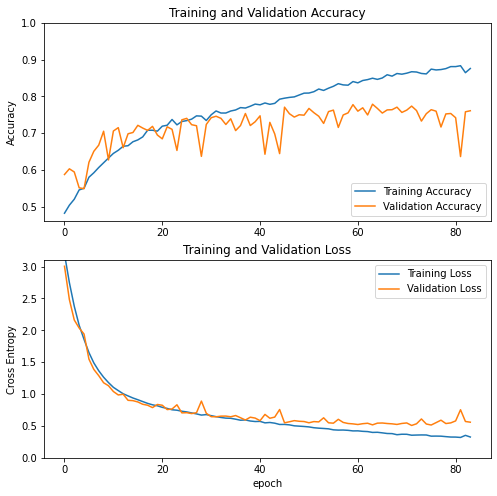

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history2.history['binary_accuracy']
val_acc = history2.history['val_binary_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
prediction= model2.predict(test_set)
y_pred=[]
for pred in prediction:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(prediction)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,1.0
72,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.0,1.0
74,0.0,0.0,0.0,0.0,1.0


In [ ]:
print(classification_report(y_test, y_pred,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.57      0.40      0.47        20
        16-Incisal Embrasure       0.61      0.70      0.65        40
                     4-color       0.91      0.62      0.74        64
                  52-Crooked       0.37      0.62      0.47        16
41-Central Incisor W/H Ratio       1.00      0.91      0.95        64

                   micro avg       0.76      0.71      0.73       204
                   macro avg       0.69      0.65      0.66       204
                weighted avg       0.80      0.71      0.74       204
                 samples avg       0.62      0.61      0.58       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model2.save("/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_tf_ww_teeth_r0-1.h5")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=25,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history3=model2.fit(x=training_set, validation_data=valid_set, epochs=150 , shuffle =True,callbacks=[es])

Epoch 1/150
83/83 [==============================] - 22s 227ms/step - loss: 0.4234 - binary_accuracy: 0.8292 - val_loss: 0.6256 - val_binary_accuracy: 0.7402
Epoch 2/150
83/83 [==============================] - 18s 220ms/step - loss: 0.4190 - binary_accuracy: 0.8305 - val_loss: 0.5644 - val_binary_accuracy: 0.7638
Epoch 3/150
83/83 [==============================] - 18s 218ms/step - loss: 0.4247 - binary_accuracy: 0.8255 - val_loss: 0.5634 - val_binary_accuracy: 0.7454
Epoch 4/150
83/83 [==============================] - 18s 220ms/step - loss: 0.4132 - binary_accuracy: 0.8336 - val_loss: 0.5414 - val_binary_accuracy: 0.7494
Epoch 5/150
83/83 [==============================] - 18s 219ms/step - loss: 0.3961 - binary_accuracy: 0.8383 - val_loss: 0.5469 - val_binary_accuracy: 0.7552
Epoch 6/150
83/83 [==============================] - 18s 219ms/step - loss: 0.3842 - binary_accuracy: 0.8468 - val_loss: 0.6482 - val_binary_accuracy: 0.6753
Epoch 7/150
83/83 [==============================] -

In [ ]:
prediction= model2.predict(test_set)
y_pred=[]
for pred in prediction:
    pred[pred>0.4]=1
    pred[pred<=0.4]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(prediction)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,1.0
72,0.0,1.0,0.0,0.0,1.0
73,0.0,1.0,1.0,0.0,1.0
74,0.0,0.0,0.0,0.0,1.0


In [ ]:
print(classification_report(y_test, y_pred,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.36      0.40      0.38        20
        16-Incisal Embrasure       0.54      0.80      0.65        40
                     4-color       0.92      0.70      0.80        64
                  52-Crooked       0.44      0.88      0.58        16
41-Central Incisor W/H Ratio       0.98      0.95      0.97        64

                   micro avg       0.71      0.78      0.75       204
                   macro avg       0.65      0.75      0.68       204
                weighted avg       0.77      0.78      0.76       204
                 samples avg       0.62      0.69      0.62       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


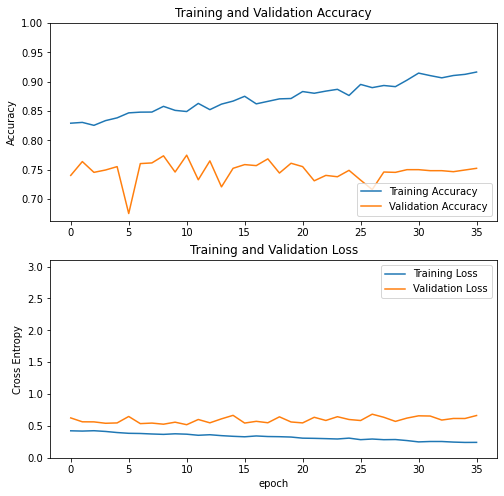

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history3.history['binary_accuracy']
val_acc = history3.history['val_binary_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

es=EarlyStopping(monitor='val_binary_accuracy',patience=25,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history4=model2.fit(x=training_set, validation_data=valid_set, epochs=150 , shuffle =True,callbacks=[es])

Epoch 1/150
83/83 [==============================] - 22s 230ms/step - loss: 0.3439 - binary_accuracy: 0.8659 - val_loss: 0.5383 - val_binary_accuracy: 0.7557
Epoch 2/150
83/83 [==============================] - 19s 229ms/step - loss: 0.3243 - binary_accuracy: 0.8803 - val_loss: 0.5415 - val_binary_accuracy: 0.7540
Epoch 3/150
83/83 [==============================] - 18s 220ms/step - loss: 0.3214 - binary_accuracy: 0.8784 - val_loss: 0.5095 - val_binary_accuracy: 0.7701
Epoch 4/150
83/83 [==============================] - 18s 218ms/step - loss: 0.3177 - binary_accuracy: 0.8793 - val_loss: 0.5816 - val_binary_accuracy: 0.7362
Epoch 5/150
83/83 [==============================] - 18s 218ms/step - loss: 0.3096 - binary_accuracy: 0.8858 - val_loss: 0.5469 - val_binary_accuracy: 0.7460
Epoch 6/150
83/83 [==============================] - 18s 218ms/step - loss: 0.3109 - binary_accuracy: 0.8852 - val_loss: 0.5690 - val_binary_accuracy: 0.7414
Epoch 7/150
83/83 [==============================] -

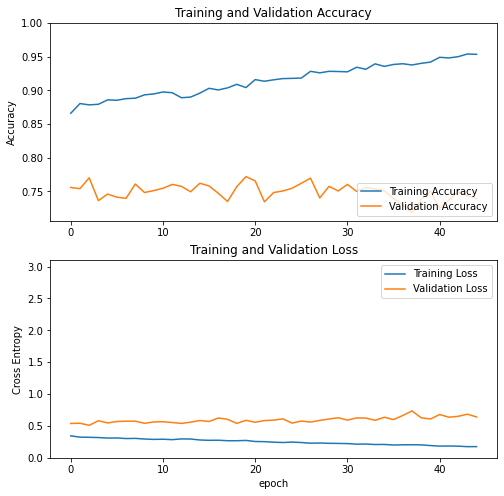

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history4.history['binary_accuracy']
val_acc = history4.history['val_binary_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
prediction= model2.predict(test_set)
y_pred=[]
for pred in prediction:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(prediction)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,1.0
72,0.0,0.0,0.0,0.0,1.0
73,0.0,0.0,0.0,0.0,1.0
74,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       1.00      0.30      0.46        20
        16-Incisal Embrasure       0.60      0.68      0.64        40
                     4-color       0.91      0.64      0.75        64
                  52-Crooked       0.38      0.31      0.34        16
41-Central Incisor W/H Ratio       0.98      0.89      0.93        64

                   micro avg       0.81      0.67      0.73       204
                   macro avg       0.78      0.56      0.63       204
                weighted avg       0.84      0.67      0.73       204
                 samples avg       0.68      0.59      0.60       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction2= model2.predict(test_set)
y_pred2=[]
for pred in prediction2:
    pred[pred>0.3]=1
    pred[pred<=0.3]=0
    y_pred2.append(pred)

y_pred2 = np.array(y_pred2)
pd.DataFrame(prediction2)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,1.0,0.0,1.0
72,0.0,0.0,0.0,0.0,1.0
73,0.0,0.0,0.0,0.0,1.0
74,0.0,0.0,0.0,0.0,1.0


In [ ]:
# y_pred2=[]
# for pred in prediction2:
#     pred[pred>0.4]=1
#     pred[pred<=0.4]=0
#     y_pred2.append(pred)

# y_pred2 = np.array(y_pred2)
# pd.DataFrame(prediction2)
print(classification_report(y_test, y_pred2,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.67      0.40      0.50        20
        16-Incisal Embrasure       0.57      0.72      0.64        40
                     4-color       0.92      0.72      0.81        64
                  52-Crooked       0.47      0.50      0.48        16
41-Central Incisor W/H Ratio       0.97      0.97      0.97        64

                   micro avg       0.79      0.75      0.77       204
                   macro avg       0.72      0.66      0.68       204
                weighted avg       0.81      0.75      0.77       204
                 samples avg       0.67      0.66      0.63       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model2.save("/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_tf_ww_teeth_r0-2.h5")

In [ ]:
model3 = Sequential()
model3.add(keras.Input(shape=(224,224,3)))
model3.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model3.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model3.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model3.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model3.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model3.add(MaxPool2D((2,2), strides=(2,2)))
 
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.load_weights('/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_teeth.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model3.layers:
    layer.trainable = False

model3.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model3.get_layer("conv4_1").trainable =True
model3.get_layer("conv4_2").trainable =True
model3.get_layer("conv5_3").trainable =True
model3.get_layer("conv5_1").trainable =True


#adding output layers
model3.add(Flatten())

model3.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))

model3.add(Dropout(0.5))

model3.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))

model3.add(Dense(5, activation='sigmoid'))
# summarize

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 128)      0         
 2D)                                                    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=25,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model3.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
83/83 [==============================] - 31s 333ms/step - loss: 3.1668 - binary_accuracy: 0.5531 - val_loss: 3.0950 - val_binary_accuracy: 0.4454
Epoch 2/100
83/83 [==============================] - 18s 220ms/step - loss: 2.7193 - binary_accuracy: 0.5554 - val_loss: 2.5177 - val_binary_accuracy: 0.5270
Epoch 3/100
83/83 [==============================] - 18s 218ms/step - loss: 2.3498 - binary_accuracy: 0.5844 - val_loss: 2.2215 - val_binary_accuracy: 0.5253
Epoch 4/100
83/83 [==============================] - 18s 218ms/step - loss: 2.0412 - binary_accuracy: 0.6076 - val_loss: 1.9079 - val_binary_accuracy: 0.6155
Epoch 5/100
83/83 [==============================] - 18s 217ms/step - loss: 1.8072 - binary_accuracy: 0.6179 - val_loss: 1.7149 - val_binary_accuracy: 0.5977
Epoch 6/100
83/83 [==============================] - 18s 219ms/step - loss: 1.6226 - binary_accuracy: 0.6317 - val_loss: 1.5377 - val_binary_accuracy: 0.6098
Epoch 7/100
83/83 [==============================] -

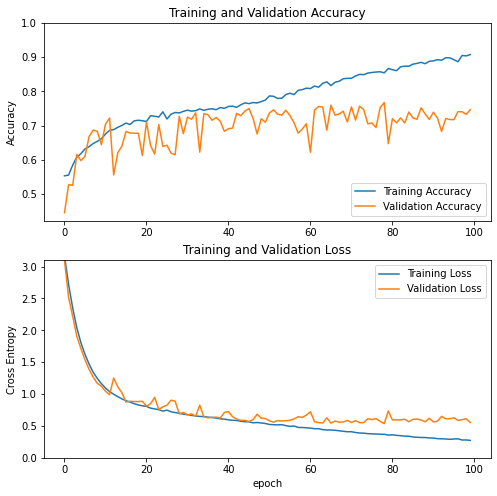

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
prediction= model3.predict(test_set)
y_pred=[]
for pred in prediction:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(prediction)

,0,1,2,3,4
0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0
72,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.0,1.0
74,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.50      0.15      0.23        20
        16-Incisal Embrasure       0.57      0.78      0.66        40
                     4-color       0.90      0.56      0.69        64
                  52-Crooked       0.33      0.50      0.40        16
41-Central Incisor W/H Ratio       0.95      0.59      0.73        64

                   micro avg       0.71      0.57      0.63       204
                   macro avg       0.65      0.52      0.54       204
                weighted avg       0.77      0.57      0.63       204
                 samples avg       0.52      0.48      0.47       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model4 = Sequential()
model4.add(keras.Input(shape=(224,224,3)))
model4.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model4.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model4.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))
 
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.load_weights('/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_teeth.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model4.layers:
    layer.trainable = False

model4.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model4.get_layer("conv4_1").trainable =True
model4.get_layer("conv4_1").trainable =True
model4.get_layer("conv4_2").trainable =True
model4.get_layer("conv5_3").trainable =True
model4.get_layer("conv5_1").trainable =True


#adding output layers
model4.add(Flatten())

model4.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dropout(0.5))

model4.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dense(5, activation='sigmoid'))
# summarize

model4.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=25,mode='max',restore_best_weights=True)
initial_learning_rate = 0.0002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model4.fit(x=training_set, validation_data=valid_set, epochs=150 ,callbacks=[es])

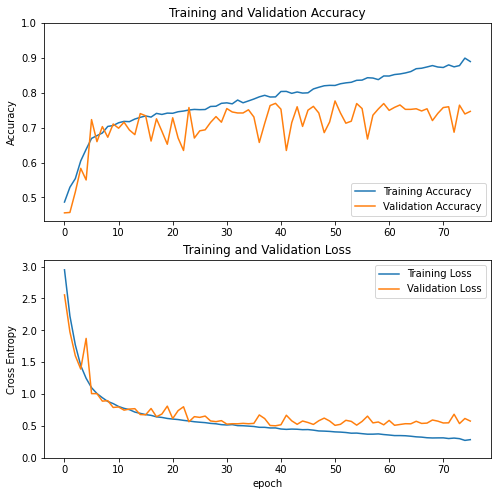

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
prediction= model4.predict(test_set)
y_pred=[]
for pred in prediction:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(prediction)

,0,1,2,3,4
0,0.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
71,0.0,1.0,1.0,0.0,1.0
72,0.0,0.0,0.0,0.0,1.0
73,0.0,0.0,0.0,0.0,1.0
74,0.0,0.0,1.0,0.0,1.0


In [ ]:
print(classification_report(y_test, y_pred,target_names=classes))


                              precision    recall  f1-score   support

                     9-gummy       0.80      0.20      0.32        20
        16-Incisal Embrasure       0.62      0.78      0.69        40
                     4-color       0.92      0.72      0.81        64
                  52-Crooked       0.37      0.69      0.48        16
41-Central Incisor W/H Ratio       0.95      0.89      0.92        64

                   micro avg       0.76      0.73      0.75       204
                   macro avg       0.73      0.65      0.64       204
                weighted avg       0.82      0.73      0.75       204
                 samples avg       0.60      0.63      0.59       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model4.save("vgg_tf_ww_teeth_r0-2.h5")
model3.save("vgg_tf_ww_teeth_r0-1.h5")

7 classes


In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/moheb432/principles-of-smile.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 6511, done.
remote: Counting objects: 100% (1732/1732), done.
remote: Compressing objects: 100% (1716/1716), done.
remote: Total 6511 (delta 34), reused 1705 (delta 16), pack-reused 4779
Receiving objects: 100% (6511/6511), 341.65 MiB | 23.88 MiB/s, done.
Resolving deltas: 100% (297/297), done.
Checking out files: 100% (7000/7000), done.
/content/cloned-repo
 add_augmented_to_csv.py		 mobile-net.ipynb
 all_teeth				 model_0_001_b16_last_model.ipynb
'biometrics_dataset - Sheet1.csv'	 old
 Copy_of_biometrics_task_model_1.ipynb	 Our_cropped_teeth
 count_samples.py			 README.md
 data_augmentation.py			 resize_with_padding.py
 dataset_2_almid.csv			 smile_dataset
 dataset_2_almid.xlsx			'teeth_not cropped'
 dataset_7_classes.csv			 Untitled.ipynb
 dataset_and_augmented.csv		 vgg.ipynb
 dataset.csv				 vgg_transfer_faces.ipynb
 dataset_split.ipynb			 vgg_transfer_padded_faces.ipynb
 Dlib-68-face-landmark.png		 vgg_transfer_padded_tee

In [ ]:
def append_ext(fn):
    return str(fn)+".jpg"

#loading dataset labels from csv 
df = pd.read_csv("/content/cloned-repo/dataset_and_augmented.csv")

# df["img"] = df["img"].apply(append_ext)

df = df.replace(np.nan, 0)
classes = ['9-gummy', '16-Incisal Embrasure', '4-color', '41-Central Incisor W/H Ratio','18-black triangle','8-gaps', '52-Crooked']
df

,img,9-gummy,16-Incisal Embrasure,4-color,41-Central Incisor W/H Ratio,18-black triangle,8-gaps,52-Crooked
0,41001_B.jpg,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,41002_B.jpg,0.0,1.0,1.0,1.0,0.0,1.0,0.0
2,41003_B.jpg,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,41004_B.jpg,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,41005_B.jpg,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2458,aug_(f15)_0_6500.jpg,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2459,aug_(f15)_0_8219.jpg,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2460,aug_(f15-a)_0_4936.jpg,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2461,aug_(f15-a)_0_7990.jpg,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 2/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/cloned-repo/all_teeth/teeth_padded/train",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/cloned-repo/all_teeth/teeth_padded/test",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/cloned-repo/all_teeth/teeth_padded/valid",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)


Found 1821 validated image filenames.
Found 488 validated image filenames.
Found 116 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 642 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1975 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2347 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# Store the data in X_test, y_test variables by iterating over the batches
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(116, 224, 224, 3) (116, 7)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_binary_accuracy',patience=10,mode='max',restore_best_weights=True)

*    no weights
*   dense 64
*   dense 16
*   7 classes
*   learning rate 0.0002

In [ ]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

# model.load_weights('/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_teeth.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False

model.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_2").trainable =True
model.get_layer("conv5_3").trainable =True
model.get_layer("conv5_1").trainable =True


#adding output layers
model.add(Flatten())

model.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(7, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
initial_learning_rate = 0.0002
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history=model.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 28s 229ms/step - loss: 2.8100 - binary_accuracy: 0.5339 - val_loss: 2.2771 - val_binary_accuracy: 0.6159
Epoch 2/100
114/114 [==============================] - 26s 224ms/step - loss: 1.8988 - binary_accuracy: 0.5998 - val_loss: 1.5961 - val_binary_accuracy: 0.6590
Epoch 3/100
114/114 [==============================] - 25s 223ms/step - loss: 1.3604 - binary_accuracy: 0.6265 - val_loss: 1.1997 - val_binary_accuracy: 0.6367
Epoch 4/100
114/114 [==============================] - 26s 226ms/step - loss: 1.0482 - binary_accuracy: 0.6460 - val_loss: 0.9800 - val_binary_accuracy: 0.6522
Epoch 5/100
114/114 [==============================] - 25s 223ms/step - loss: 0.8666 - binary_accuracy: 0.6682 - val_loss: 0.8233 - val_binary_accuracy: 0.6168
Epoch 6/100
114/114 [==============================] - 25s 223ms/step - loss: 0.7528 - binary_accuracy: 0.6827 - val_loss: 0.7592 - val_binary_accuracy: 0.6338
Epoch 7/100
114/114 [===================

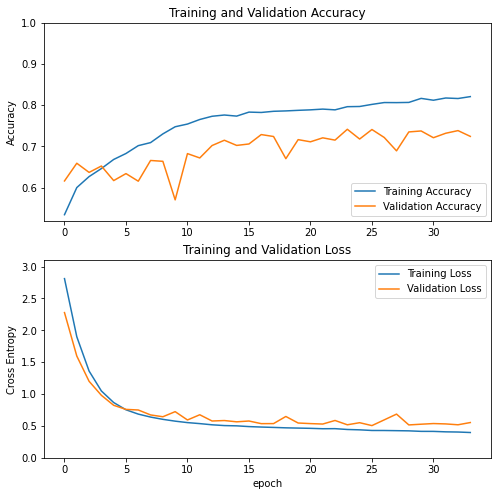

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)
    
pd.DataFrame(predictions)

,0,1,2,3,4,5,6
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.77      0.36      0.49        28
        16-Incisal Embrasure       0.72      0.38      0.50        68
                     4-color       0.90      0.57      0.70        80
41-Central Incisor W/H Ratio       0.50      0.11      0.18        56
           18-black triangle       0.00      0.00      0.00        24
                      8-gaps       0.92      0.39      0.55        28
                  52-Crooked       0.00      0.00      0.00        16

                   micro avg       0.75      0.33      0.46       300
                   macro avg       0.54      0.26      0.35       300
                weighted avg       0.65      0.33      0.43       300
                 samples avg       0.35      0.24      0.27       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*   weights = vgg_faces_weights
*   dense 64
*   dense 16
*   7 classes
*   learning rate 0.0002

In [ ]:
model1 = Sequential()
model1.add(keras.Input(shape=(224,224,3)))
model1.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model1.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model1.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model1.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model1.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model1.add(MaxPool2D((2,2), strides=(2,2)))
 
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model1.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model1.add(MaxPool2D((2,2), strides=(2,2)))

model1.load_weights('/content/drive/MyDrive/Colab Notebooks/biometrics/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model1.layers:
    layer.trainable = False

model1.get_layer("conv3_1").trainable =True
#model1.get_layer("conv3_3").trainable =True
#model1.get_layer("conv4_1").trainable =True
model1.get_layer("conv4_1").trainable =True
model1.get_layer("conv4_2").trainable =True
model1.get_layer("conv5_3").trainable =True
model1.get_layer("conv5_1").trainable =True


#adding output layers
model1.add(Flatten())

model1.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model1.add(BatchNormalization())
model1.add(Activation("relu"))

model1.add(Dropout(0.5))

model1.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model1.add(BatchNormalization())
model1.add(Activation("relu"))

model1.add(Dense(7, activation='sigmoid'))
# summarize

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
initial_learning_rate = 0.0002
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history1=model1.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 29s 242ms/step - loss: 2.8075 - binary_accuracy: 0.5241 - val_loss: 2.3805 - val_binary_accuracy: 0.5117
Epoch 2/100
114/114 [==============================] - 27s 236ms/step - loss: 1.9612 - binary_accuracy: 0.6021 - val_loss: 1.6827 - val_binary_accuracy: 0.5887
Epoch 3/100
114/114 [==============================] - 27s 235ms/step - loss: 1.4437 - binary_accuracy: 0.6579 - val_loss: 1.2565 - val_binary_accuracy: 0.6900
Epoch 4/100
114/114 [==============================] - 26s 226ms/step - loss: 1.1228 - binary_accuracy: 0.7045 - val_loss: 1.1667 - val_binary_accuracy: 0.6025
Epoch 5/100
114/114 [==============================] - 27s 235ms/step - loss: 0.9258 - binary_accuracy: 0.7381 - val_loss: 0.8842 - val_binary_accuracy: 0.7187
Epoch 6/100
114/114 [==============================] - 27s 237ms/step - loss: 0.7924 - binary_accuracy: 0.7719 - val_loss: 0.8007 - val_binary_accuracy: 0.7324
Epoch 7/100
114/114 [===================

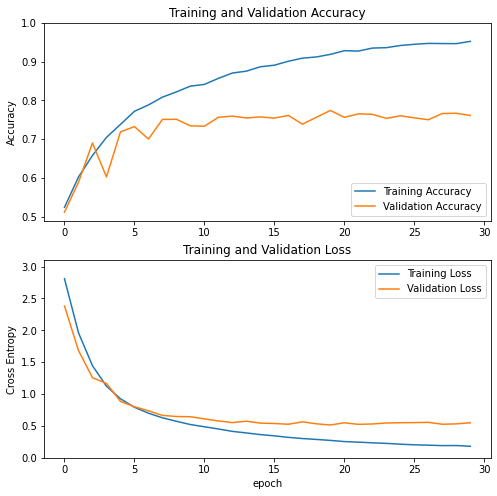

In [ ]:
acc = history1.history['binary_accuracy']
val_acc = history1.history['val_binary_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions1= model1.predict(test_set)
y_pred1=[]
for pred in predictions1:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred1.append(pred)
    
pd.DataFrame(predictions1)

,0,1,2,3,4,5,6
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred1,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.82      0.64      0.72        28
        16-Incisal Embrasure       0.71      0.62      0.66        68
                     4-color       0.86      0.75      0.80        80
41-Central Incisor W/H Ratio       0.61      0.45      0.52        56
           18-black triangle       0.20      0.04      0.07        24
                      8-gaps       1.00      0.32      0.49        28
                  52-Crooked       0.60      0.38      0.46        16

                   micro avg       0.75      0.54      0.62       300
                   macro avg       0.69      0.46      0.53       300
                weighted avg       0.72      0.54      0.60       300
                 samples avg       0.55      0.45      0.47       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*   weights = vgg_teeth
*   dense 64
*   dense 16
*   7 classes
*   learning rate 0.0002

In [ ]:
model2 = Sequential()
model2.add(keras.Input(shape=(224,224,3)))
model2.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model2.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model2.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model2.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model2.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model2.add(MaxPool2D((2,2), strides=(2,2)))
 
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model2.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model2.add(MaxPool2D((2,2), strides=(2,2)))

model2.load_weights('/content/drive/MyDrive/biometrics/vgg_teeth.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model2.layers:
    layer.trainable = False

model2.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model2.get_layer("conv4_1").trainable =True
model2.get_layer("conv4_2").trainable =True
model2.get_layer("conv5_3").trainable =True
model2.get_layer("conv5_1").trainable =True


#adding output layers
model2.add(Flatten())

model2.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))

model2.add(Dropout(0.5))

model2.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))

model2.add(Dense(7, activation='sigmoid'))
# summarize

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 53, 53, 128)      0         
 2D)                                                  

In [ ]:
initial_learning_rate = 0.0002
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history2=model2.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 50s 293ms/step - loss: 2.7495 - binary_accuracy: 0.5485 - val_loss: 2.6223 - val_binary_accuracy: 0.4028
Epoch 2/100
114/114 [==============================] - 24s 214ms/step - loss: 1.8545 - binary_accuracy: 0.5910 - val_loss: 1.5702 - val_binary_accuracy: 0.5834
Epoch 3/100
114/114 [==============================] - 24s 214ms/step - loss: 1.3438 - binary_accuracy: 0.6416 - val_loss: 1.2525 - val_binary_accuracy: 0.5773
Epoch 4/100
114/114 [==============================] - 24s 215ms/step - loss: 1.0599 - binary_accuracy: 0.6817 - val_loss: 1.0222 - val_binary_accuracy: 0.6546
Epoch 5/100
114/114 [==============================] - 25s 215ms/step - loss: 0.8985 - binary_accuracy: 0.7111 - val_loss: 0.9082 - val_binary_accuracy: 0.6718
Epoch 6/100
114/114 [==============================] - 24s 214ms/step - loss: 0.8198 - binary_accuracy: 0.7100 - val_loss: 0.8556 - val_binary_accuracy: 0.6651
Epoch 7/100
114/114 [===================

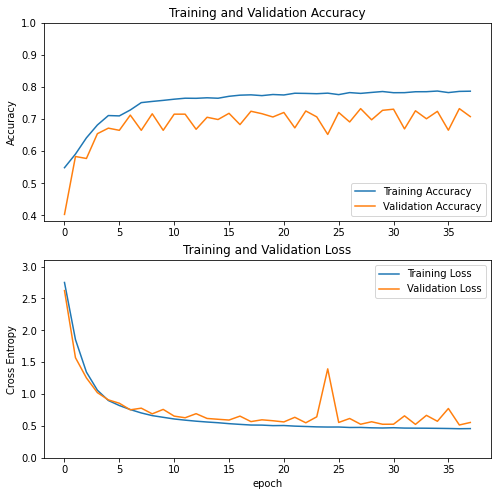

In [ ]:
acc = history2.history['binary_accuracy']
val_acc = history2.history['val_binary_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions2= model2.predict(test_set)
y_pred2=[]
for pred in predictions2:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred2.append(pred)
    
pd.DataFrame(predictions2)

,0,1,2,3,4,5,6
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,0.0,1.0,1.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.00      0.00      0.00        28
        16-Incisal Embrasure       0.66      0.65      0.65        68
                     4-color       0.87      0.75      0.81        80
41-Central Incisor W/H Ratio       0.55      0.64      0.60        56
           18-black triangle       0.00      0.00      0.00        24
                      8-gaps       0.00      0.00      0.00        28
                  52-Crooked       0.00      0.00      0.00        16

                   micro avg       0.70      0.47      0.56       300
                   macro avg       0.30      0.29      0.29       300
                weighted avg       0.48      0.47      0.47       300
                 samples avg       0.43      0.40      0.40       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history2=model2.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 26s 217ms/step - loss: 0.4707 - binary_accuracy: 0.7836 - val_loss: 0.6240 - val_binary_accuracy: 0.6765
Epoch 2/100
114/114 [==============================] - 24s 214ms/step - loss: 0.4646 - binary_accuracy: 0.7861 - val_loss: 0.5308 - val_binary_accuracy: 0.7280
Epoch 3/100
114/114 [==============================] - 24s 214ms/step - loss: 0.4609 - binary_accuracy: 0.7879 - val_loss: 0.6189 - val_binary_accuracy: 0.6824
Epoch 4/100
114/114 [==============================] - 24s 215ms/step - loss: 0.4621 - binary_accuracy: 0.7861 - val_loss: 0.5272 - val_binary_accuracy: 0.7310
Epoch 5/100
114/114 [==============================] - 25s 215ms/step - loss: 0.4585 - binary_accuracy: 0.7883 - val_loss: 0.5262 - val_binary_accuracy: 0.7266
Epoch 6/100
114/114 [==============================] - 24s 214ms/step - loss: 0.4592 - binary_accuracy: 0.7887 - val_loss: 0.5685 - val_binary_accuracy: 0.7307
Epoch 7/100
114/114 [===================

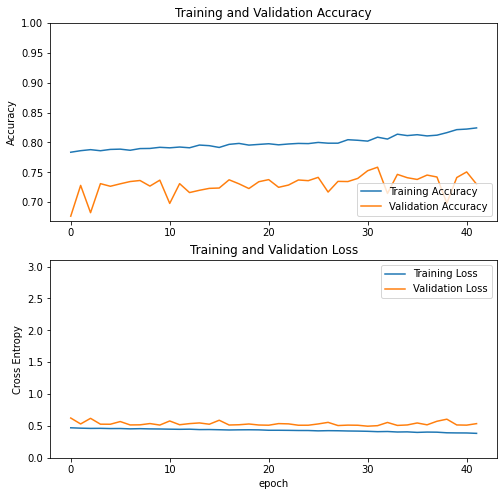

In [ ]:
acc = history2.history['binary_accuracy']
val_acc = history2.history['val_binary_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions2= model2.predict(test_set)
y_pred2=[]
for pred in predictions2:
    pred[pred>0.3]=1
    pred[pred<=0.3]=0
    y_pred2.append(pred)
    
pd.DataFrame(predictions2)

,0,1,2,3,4,5,6
0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,1.0,1.0,0.0,0.0,0.0,0.0,0.0
112,0.0,1.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred2,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.27      0.36      0.31        28
        16-Incisal Embrasure       0.69      0.71      0.70        68
                     4-color       0.91      0.78      0.84        80
41-Central Incisor W/H Ratio       0.56      0.79      0.65        56
           18-black triangle       0.50      0.04      0.08        24
                      8-gaps       0.81      0.46      0.59        28
                  52-Crooked       0.34      0.69      0.46        16

                   micro avg       0.62      0.63      0.63       300
                   macro avg       0.58      0.55      0.52       300
                weighted avg       0.66      0.63      0.62       300
                 samples avg       0.45      0.52      0.46       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# weights --> vgg_tf_ww_teeth_r0-2.h5

In [ ]:
model3 = Sequential()
model3.add(keras.Input(shape=(224,224,3)))
model3.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model3.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model3.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model3.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model3.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model3.add(MaxPool2D((2,2), strides=(2,2)))
 
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model3.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model3.add(MaxPool2D((2,2), strides=(2,2)))

model3.load_weights('/content/drive/MyDrive/biometrics/vgg_tf_ww_teeth_r0-2.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model3.layers:
    layer.trainable = False

model3.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model3.get_layer("conv4_1").trainable =True
model3.get_layer("conv4_2").trainable =True
model3.get_layer("conv5_3").trainable =True
model3.get_layer("conv5_1").trainable =True


#adding output layers
model3.add(Flatten())

model3.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))

model3.add(Dropout(0.5))

model3.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))

model3.add(Dense(7, activation='sigmoid'))
# summarize

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
initial_learning_rate = 0.0002
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history3=model3.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 28s 228ms/step - loss: 2.7094 - binary_accuracy: 0.6244 - val_loss: 2.2142 - val_binary_accuracy: 0.6417
Epoch 2/100
114/114 [==============================] - 24s 214ms/step - loss: 1.8301 - binary_accuracy: 0.6877 - val_loss: 1.6935 - val_binary_accuracy: 0.6537
Epoch 3/100
114/114 [==============================] - 25s 219ms/step - loss: 1.3293 - binary_accuracy: 0.7233 - val_loss: 1.2301 - val_binary_accuracy: 0.6774
Epoch 4/100
114/114 [==============================] - 24s 214ms/step - loss: 1.0330 - binary_accuracy: 0.7494 - val_loss: 1.0588 - val_binary_accuracy: 0.5948
Epoch 5/100
114/114 [==============================] - 25s 215ms/step - loss: 0.8653 - binary_accuracy: 0.7628 - val_loss: 0.8826 - val_binary_accuracy: 0.6976
Epoch 6/100
114/114 [==============================] - 25s 216ms/step - loss: 0.7485 - binary_accuracy: 0.7806 - val_loss: 0.7959 - val_binary_accuracy: 0.7146
Epoch 7/100
114/114 [===================

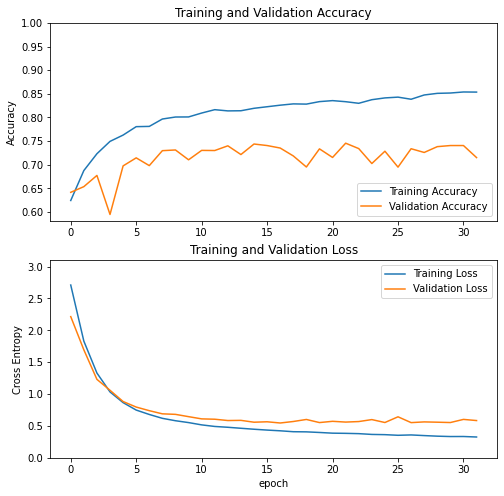

In [ ]:
acc = history3.history['binary_accuracy']
val_acc = history3.history['val_binary_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions3= model3.predict(test_set)
y_pred3=[]
for pred in predictions3:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred3.append(pred)
    
pd.DataFrame(predictions3)

,0,1,2,3,4,5,6
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred3,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.58      0.54      0.56        28
        16-Incisal Embrasure       0.67      0.60      0.64        68
                     4-color       0.88      0.62      0.73        80
41-Central Incisor W/H Ratio       0.53      0.52      0.52        56
           18-black triangle       0.00      0.00      0.00        24
                      8-gaps       0.56      0.18      0.27        28
                  52-Crooked       0.58      0.44      0.50        16

                   micro avg       0.67      0.49      0.57       300
                   macro avg       0.54      0.41      0.46       300
                weighted avg       0.62      0.49      0.54       300
                 samples avg       0.38      0.39      0.37       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
initial_learning_rate = 0.0002
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history3=model3.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 27s 217ms/step - loss: 0.3651 - binary_accuracy: 0.8449 - val_loss: 0.5556 - val_binary_accuracy: 0.7307
Epoch 2/100
114/114 [==============================] - 24s 211ms/step - loss: 0.3581 - binary_accuracy: 0.8471 - val_loss: 0.5665 - val_binary_accuracy: 0.7140
Epoch 3/100
114/114 [==============================] - 24s 211ms/step - loss: 0.3514 - binary_accuracy: 0.8485 - val_loss: 0.6036 - val_binary_accuracy: 0.7032
Epoch 4/100
114/114 [==============================] - 24s 212ms/step - loss: 0.3484 - binary_accuracy: 0.8495 - val_loss: 0.5989 - val_binary_accuracy: 0.7026
Epoch 5/100
114/114 [==============================] - 24s 212ms/step - loss: 0.3412 - binary_accuracy: 0.8494 - val_loss: 0.5758 - val_binary_accuracy: 0.7140
Epoch 6/100
114/114 [==============================] - 24s 212ms/step - loss: 0.3372 - binary_accuracy: 0.8524 - val_loss: 0.5463 - val_binary_accuracy: 0.7412
Epoch 7/100
114/114 [===================

In [ ]:
predictions3= model3.predict(test_set)
y_pred3=[]
for pred in predictions3:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred3.append(pred)
    
pd.DataFrame(predictions3)

,0,1,2,3,4,5,6
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112,0.0,1.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred3,target_names=classes))


                              precision    recall  f1-score   support

                     9-gummy       0.69      0.39      0.50        28
        16-Incisal Embrasure       0.66      0.69      0.68        68
                     4-color       0.90      0.66      0.76        80
41-Central Incisor W/H Ratio       0.61      0.62      0.62        56
           18-black triangle       0.00      0.00      0.00        24
                      8-gaps       0.82      0.32      0.46        28
                  52-Crooked       0.53      0.50      0.52        16

                   micro avg       0.71      0.54      0.62       300
                   macro avg       0.60      0.46      0.51       300
                weighted avg       0.67      0.54      0.59       300
                 samples avg       0.52      0.44      0.45       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model4 = Sequential()
model4.add(keras.Input(shape=(224,224,3)))
model4.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model4.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model4.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))
 
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

# model4.load_weights('/content/drive/MyDrive/biometrics/vgg_tf_ww_teeth_r0-2.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model4.layers:
    layer.trainable = False

model4.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model4.get_layer("conv4_1").trainable =True
model4.get_layer("conv4_2").trainable =True
model4.get_layer("conv5_3").trainable =True
model4.get_layer("conv5_1").trainable =True


#adding output layers
model4.add(Flatten())

model4.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.025)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dropout(0.5))

model4.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.025)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dropout(0.5))

model4.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.025)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dense(7, activation='sigmoid'))
# summarize

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
initial_learning_rate = 0.0002
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history4=model4.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 27s 221ms/step - loss: 3.8832 - binary_accuracy: 0.5521 - val_loss: 3.1861 - val_binary_accuracy: 0.5764
Epoch 2/100
114/114 [==============================] - 25s 219ms/step - loss: 2.7068 - binary_accuracy: 0.6097 - val_loss: 2.3054 - val_binary_accuracy: 0.5738
Epoch 3/100
114/114 [==============================] - 25s 221ms/step - loss: 1.9909 - binary_accuracy: 0.6513 - val_loss: 1.7680 - val_binary_accuracy: 0.6153
Epoch 4/100
114/114 [==============================] - 26s 224ms/step - loss: 1.5609 - binary_accuracy: 0.6769 - val_loss: 1.4382 - val_binary_accuracy: 0.6721
Epoch 5/100
114/114 [==============================] - 25s 220ms/step - loss: 1.2903 - binary_accuracy: 0.7017 - val_loss: 1.2239 - val_binary_accuracy: 0.7002
Epoch 6/100
114/114 [==============================] - 25s 216ms/step - loss: 1.1147 - binary_accuracy: 0.7195 - val_loss: 1.0497 - val_binary_accuracy: 0.7117
Epoch 7/100
114/114 [===================

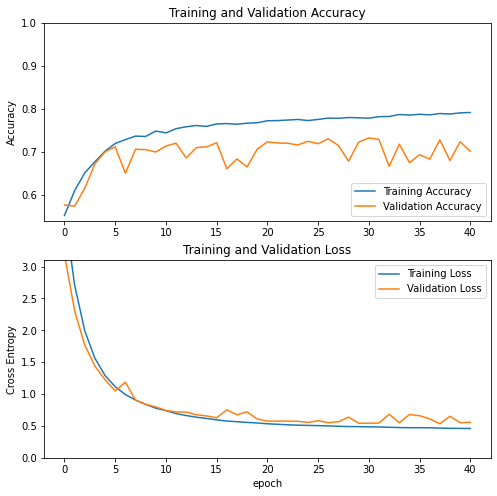

In [ ]:
acc = history4.history['binary_accuracy']
val_acc = history4.history['val_binary_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions4= model4.predict(test_set)
y_pred4=[]
for pred in predictions4:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred4.append(pred)
    
pd.DataFrame(predictions4)

,0,1,2,3,4,5,6
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred4,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       0.00      0.00      0.00        28
        16-Incisal Embrasure       0.65      0.63      0.64        68
                     4-color       0.88      0.74      0.80        80
41-Central Incisor W/H Ratio       0.58      0.68      0.62        56
           18-black triangle       0.00      0.00      0.00        24
                      8-gaps       0.00      0.00      0.00        28
                  52-Crooked       0.00      0.00      0.00        16

                   micro avg       0.70      0.47      0.56       300
                   macro avg       0.30      0.29      0.30       300
                weighted avg       0.49      0.47      0.48       300
                 samples avg       0.41      0.39      0.39       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model4 = Sequential()
model4.add(keras.Input(shape=(224,224,3)))
model4.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model4.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model4.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model4.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))
 
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model4.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model4.add(MaxPool2D((2,2), strides=(2,2)))

model4.load_weights('/content/drive/MyDrive/biometrics/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model4.layers:
    layer.trainable = False

model4.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model4.get_layer("conv4_1").trainable =True
model4.get_layer("conv4_2").trainable =True
model4.get_layer("conv5_3").trainable =True
model4.get_layer("conv5_1").trainable =True


#adding output layers
model4.add(Flatten())

model4.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.025)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dropout(0.5))

model4.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.025)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dropout(0.5))

model4.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.025)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))

model4.add(Dense(7, activation='sigmoid'))
# summarize

model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
initial_learning_rate = 0.0002
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
#fit model
history4=model4.fit(x=training_set, validation_data=valid_set, epochs=100 ,callbacks=[es])

Epoch 1/100
114/114 [==============================] - 48s 219ms/step - loss: 3.8430 - binary_accuracy: 0.5554 - val_loss: 3.2566 - val_binary_accuracy: 0.5158
Epoch 2/100
114/114 [==============================] - 25s 216ms/step - loss: 2.6782 - binary_accuracy: 0.5807 - val_loss: 2.2808 - val_binary_accuracy: 0.6057
Epoch 3/100
114/114 [==============================] - 25s 216ms/step - loss: 1.9879 - binary_accuracy: 0.6046 - val_loss: 1.7314 - val_binary_accuracy: 0.6323
Epoch 4/100
114/114 [==============================] - 25s 216ms/step - loss: 1.5735 - binary_accuracy: 0.6300 - val_loss: 1.7233 - val_binary_accuracy: 0.5647
Epoch 5/100
114/114 [==============================] - 25s 216ms/step - loss: 1.3311 - binary_accuracy: 0.6385 - val_loss: 1.2497 - val_binary_accuracy: 0.6150
Epoch 6/100
114/114 [==============================] - 25s 216ms/step - loss: 1.1647 - binary_accuracy: 0.6676 - val_loss: 1.1277 - val_binary_accuracy: 0.7055
Epoch 7/100
114/114 [===================

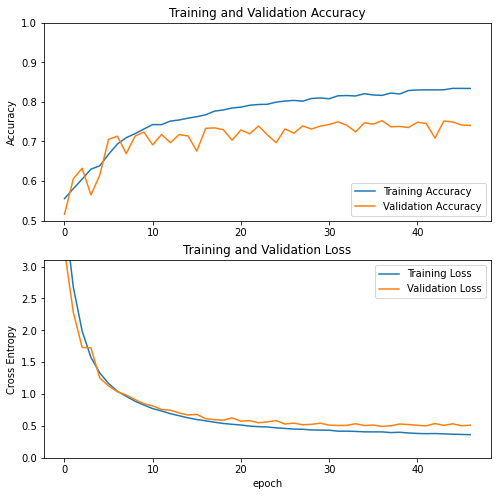

In [ ]:
acc = history4.history['binary_accuracy']
val_acc = history4.history['val_binary_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions4= model4.predict(test_set)
y_pred4=[]
for pred in predictions4:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred4.append(pred)
    
pd.DataFrame(predictions4)

,0,1,2,3,4,5,6
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(classification_report(y_test, y_pred4,target_names=classes))

                              precision    recall  f1-score   support

                     9-gummy       1.00      0.50      0.67        28
        16-Incisal Embrasure       0.69      0.68      0.68        68
                     4-color       0.87      0.76      0.81        80
41-Central Incisor W/H Ratio       0.55      0.71      0.62        56
           18-black triangle       0.00      0.00      0.00        24
                      8-gaps       0.89      0.29      0.43        28
                  52-Crooked       0.00      0.00      0.00        16

                   micro avg       0.73      0.56      0.63       300
                   macro avg       0.57      0.42      0.46       300
                weighted avg       0.67      0.56      0.59       300
                 samples avg       0.48      0.46      0.46       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


k-fold cross validation

In [ ]:
import pandas as pd
# from sklearn.model_selection import StratifiedKFold
# from sklearn import cross_validation
from sklearn.model_selection import KFold
df_metrics = pd.DataFrame()
kf = KFold(n_splits = 10, shuffle = True, random_state = None)
for train_index, test_index in kf.split(dataframe):
    trainData = dataframe.iloc[train_index]
    testData = dataframe.iloc[test_index]
    print('Initializing Kfold %s'%str(i))
    print('Train shape:',trainData.shape)
    print('Test shape:',testData.shape)
    epochs = 30